# 第5章 （2, 3）ブースティング (AdaBoost)

バギングでは複数の弱学習器を独立に学習したが，ブースティングでは複数の弱学習器を順番に学習する．
<img src="work/2.png" width="600">

集団学習では，各弱学習器であるため，すべてのトレーニングデータを正しく学習できない．そこで，うまく学習できない難しいデータに対して強い重み付けを行い，逆に正しく学習できる簡単なデータには弱い重み付けを行って，べつの弱学習器で学習を行う．これを複数の弱学習器で行えば難しい学習データも正しく学習できるのではないかと期待するものである．このように重み付けするブースティングは様々提案されているが，もっとも標準的な手法はアダブーストである．アダブーストとは，アダプティブ・ブースティングの略語で適応的なブースティングという意味である．アダブーストのイメージ図を以下に示す．

<img src="work/3.png" width="600">


上の図の1では，まだ学習前なので，すべてのデータは同じ重み付けである．最初の弱学習器によって，1の上側と下側で分類を行ったとする．このとき，四角が2つ間違っている．そのため，この2個を強く重み付けし，残りの四角3つと丸5つは弱く重み付けする．2では，この重み付けされたデータを学習する．今度は，左側の四角2は正解したが，上側の四角3つが間違えたの強く重み付けする．そして，正しく分類された左側の四角2個と丸5個は弱く重み付けする．これを繰り返していく．

アダブーストは間違えた学習データ，重点的に学習を行うため効果が高いが，バギングと異なり並列計算はできない．

重みの更新は，

$$
w_i \leftarrow w_i \exp (-\theta_j \varphi_j(\mathbf{x}_i)y_i)
$$

## アダブーストの実装

In [3]:
# 魚データ
# 特徴ベクトル：2次元（体長, 体重）
# ラベル数：2（サケ(A)とスズキ(B)）

# 確率密度関数で生成
# 分散共分散行列で楕円を指定
# ただし，データのオーバーラップを生じさせて，難しくする．
# トレーニングデータとテストデータを作成する．

import numpy as np
import pandas as pd

# 乱数の種を初期化
np.random.seed(0)

# データ数
numA = 200 # Aをサケ
numB = 200 # Bをスズキ
numAll = numA + numB

# 平均
muA = [-2,2]
muB = [2,-2]

# 共分散
cov = [[30,15],[15,30]]

# 入力信号を生成
xA, yA = np.random.multivariate_normal(muA, cov, numA).T
xB, yB = np.random.multivariate_normal(muB, cov, numB).T

# 教師信号を生成
clsA = [1 for i in range(numA)]
clsB = [0 for i in range(numB)]

# DataFrameに変換
dfA = pd.DataFrame(np.array([xA,yA,clsA]).T, columns=['cm','kg','cls'])
dfB = pd.DataFrame(np.array([xB,yB,clsB]).T, columns=['cm','kg','cls'])
dfAll = pd.concat([dfA,dfB],axis=0)
dfAll = dfAll.reset_index(drop=True)

import sklearn.preprocessing as skl
dfAll.cm = skl.scale(dfAll.cm) #正規化
dfAll.kg = skl.scale(dfAll.kg) #正規化

from sklearn.model_selection import train_test_split
X = dfAll[['cm','kg']].values
y = dfAll[['cls']].values
y = y.reshape(len(y),) # ベクトルにする
y = np.array(y, dtype=np.int64)


X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=0)

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier

models = {
    'Tree': DecisionTreeClassifier(random_state=0),
    'Bagging': BaggingClassifier(DecisionTreeClassifier(random_state=0), n_estimators=100, random_state=0),
    'AdaBoost': AdaBoostClassifier(DecisionTreeClassifier(random_state=0), n_estimators=100, random_state=0),
}

scores = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    scores[(model_name, 'train_score')] = model.score(X_train, y_train)
    scores[(model_name, 'test_score')] = model.score(X_test, y_test)

pd.Series(scores).unstack()

,test_score,train_score
AdaBoost,0.69,1.0
Bagging,0.71,1.0
Tree,0.67,1.0


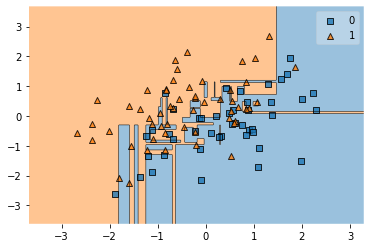

In [14]:
# 領域を表示
from mlxtend.plotting import plot_decision_regions
predicted = model.predict(X_test)
plot_decision_regions(X_test, y_test, model)

この問題では，アダブーストよりもバギングの方が性能がよい．今回扱っている問題は特徴ベクトルが2次元であり簡単な問題である．問題がより複雑なとき，アダブーストの方が良くなることが多い．